Подключем необходимые библиотеки:

In [1]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import scipy
from google.colab import files
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [ ]:
uploaded = files.upload()

Saving insurance.csv to insurance.csv


Проведем первичное обследование набора данных. Выполним
загрузку данных (рис. 6.2). Такое представление обучающей и тестовой
выборок не дает осмысленного представления о структуре данных, вывод
тяжело читается.

In [ ]:
train_df = pd.read_csv('/content/howpop_train.csv')
test_df = pd.read_csv('/content/howpop_test.csv')
print('//////////////////////////////////////////')
print(train_df.head())
print('//////////////////////////////////////////')
print(test_df.head()) # Рис 6.2

//////////////////////////////////////////
                                url        domain  post_id  \
0  https://habrahabr.ru/post/18284/  habrahabr.ru    18284   
1  https://habrahabr.ru/post/18285/  habrahabr.ru    18285   
2  https://habrahabr.ru/post/18286/  habrahabr.ru    18286   
3  https://habrahabr.ru/post/18291/  habrahabr.ru    18291   
4  https://geektimes.ru/post/18294/  geektimes.ru    18294   

             published      author     flow  polling  content_len  \
0  2008-01-01 18:19:00      @Tapac  develop    False         4305   
1  2008-01-01 18:30:00  @DezmASter   design    False         7344   
2  2008-01-01 18:34:00  @DezmASter   design    False         8431   
3  2008-01-02 01:32:00    @Taoorus   design    False         5662   
4  2008-01-02 14:34:00    @dennydo      NaN    False         3706   

                                               title  comments  favs  views  \
0     Новогодний подарок блоггерам — WordPress 2.3.2         0     0    236   
1  Сумасшед

Трансформируем вывод следующим образом (рис. 6.3): в
методе head() будем выводить одну строку, а также транспонируем вывод.

In [ ]:
train_df = pd.read_csv('/content/howpop_train.csv')
test_df = pd.read_csv('/content/howpop_test.csv')
print('//////////////////////////////////////////')
print(train_df.head(1).T)
print('//////////////////////////////////////////')
print(test_df.head(1).T)

//////////////////////////////////////////
                                                               0
url                             https://habrahabr.ru/post/18284/
domain                                              habrahabr.ru
post_id                                                    18284
published                                    2008-01-01 18:19:00
author                                                    @Tapac
flow                                                     develop
polling                                                    False
content_len                                                 4305
title             Новогодний подарок блоггерам — WordPress 2.3.2
comments                                                       0
favs                                                           0
views                                                        236
votes_plus                                                   0.0
votes_minus                                    

Определим размер выборок:


In [ ]:
print('Тестовый набор: \t', test_df.shape)
print('Обучающая выборка: \t', train_df.shape)

Тестовый набор: 	 (3990, 9)
Обучающая выборка: 	 (134137, 17)


Получим общую информацию по фрейму:

In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134137 entries, 0 to 134136
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   url               134137 non-null  object 
 1   domain            134137 non-null  object 
 2   post_id           134137 non-null  int64  
 3   published         134137 non-null  object 
 4   author            97657 non-null   object 
 5   flow              97048 non-null   object 
 6   polling           134137 non-null  bool   
 7   content_len       134137 non-null  int64  
 8   title             134137 non-null  object 
 9   comments          134137 non-null  int64  
 10  favs              134137 non-null  int64  
 11  views             134137 non-null  int64  
 12  votes_plus        133566 non-null  float64
 13  votes_minus       133566 non-null  float64
 14  views_lognorm     134137 non-null  float64
 15  favs_lognorm      134137 non-null  float64
 16  comments_lognorm  13

Рассмотрим, каким образом упорядочены данные в train_df по
временной оси (по published). Для этого используем код (рис. 6.7). Данные
упорядочены по полю published (рис. 6.8).

Ряд с датами столбца published
0   2008-01-01 18:19:00
1   2008-01-01 18:30:00
2   2008-01-01 18:34:00
3   2008-01-02 01:32:00
4   2008-01-02 14:34:00
Name: published, dtype: datetime64[ns]
Размер объекта Series:  (134137, 17)


<Axes: >

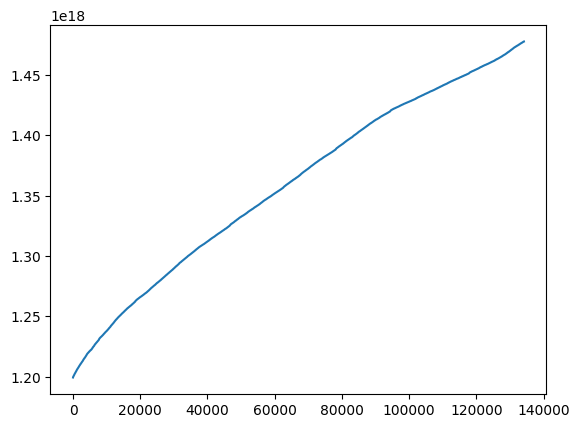

In [ ]:
# копируем столбец данных published
ser_data = train_df['published'].apply(lambda ts: pd.to_datetime(ts))
print('Ряд с датами столбца published')
print(ser_data.head())
print('Размер объекта Series: ', train_df.shape)
ser_data.apply(lambda el: el.value).plot()

Продолжим анализировать набор данных и определим,
существует ли корреляция между отдельными признаками. Для этого
воспользуемся методом pandas.DataFrame.corr(). Вызвав реализацию функции
по умолчанию train_df.corr(), получим коэффициенты корреляции.

In [ ]:
# Оставляем только числовые столбцы
numeric_train_df = train_df.select_dtypes(include=['number'])

# Вычисляем корреляцию
corr = numeric_train_df.corr()
corr

,post_id,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,1.000000,0.241384,-0.147763,0.089313,0.132385,-0.187885,-0.235594,-0.010376,-0.005845,-0.001605
content_len,0.241384,1.000000,-0.023544,0.308194,0.204101,0.068779,-0.078686,0.246063,0.356481,0.073132
comments,-0.147763,-0.023544,1.000000,0.164166,0.290035,0.613961,0.457638,0.349568,0.278942,0.662740
favs,0.089313,0.308194,0.164166,1.000000,0.634304,0.416241,0.062877,0.456097,0.587982,0.263239
views,0.132385,0.204101,0.290035,0.634304,1.000000,0.396849,0.128654,0.585105,0.406782,0.326427
votes_plus,-0.187885,0.068779,0.613961,0.416241,0.396849,1.000000,0.464168,0.414232,0.449712,0.525081
votes_minus,-0.235594,-0.078686,0.457638,0.062877,0.128654,0.464168,1.000000,0.146609,0.088226,0.355458
views_lognorm,-0.010376,0.246063,0.349568,0.456097,0.585105,0.414232,0.146609,1.000000,0.688811,0.546530
favs_lognorm,-0.005845,0.356481,0.278942,0.587982,0.406782,0.449712,0.088226,0.688811,1.000000,0.479476
comments_lognorm,-0.001605,0.073132,0.662740,0.263239,0.326427,0.525081,0.355458,0.546530,0.479476,1.000000


По данной матрице необходимо определить коррелирующие рпизнаки
(с коэффициентом корреляции больше 0.9). Искать такие значения по
представленной матрице – достаточно сложная задача, которая повлечет
ошибки, поэтому представим матрицу корреляции в удобном для анализа
виде:

In [ ]:
corr[corr>0.9].replace({np.nan : ''})

,post_id,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,1.0,,,,,,,,,
content_len,,1.0,,,,,,,,
comments,,,1.0,,,,,,,
favs,,,,1.0,,,,,,
views,,,,,1.0,,,,,
votes_plus,,,,,,1.0,,,,
votes_minus,,,,,,,1.0,,,
views_lognorm,,,,,,,,1.0,,
favs_lognorm,,,,,,,,,1.0,
comments_lognorm,,,,,,,,,,1.0


Таким образом устанавливаем, что признаки набора данных
независимы.

Проведем еще одно исследование: определим как распределены
публикации по годам

In [ ]:
df = train_df.copy()
df['published'] = pd.to_datetime(df['published']).dt.year
ss = df['published'].value_counts()
print(ss.sort_index())

published
2008     7743
2009    10783
2010    13091
2011    15063
2012    15972
2013    15537
2014    16180
2015    23452
2016    16316
Name: count, dtype: int64


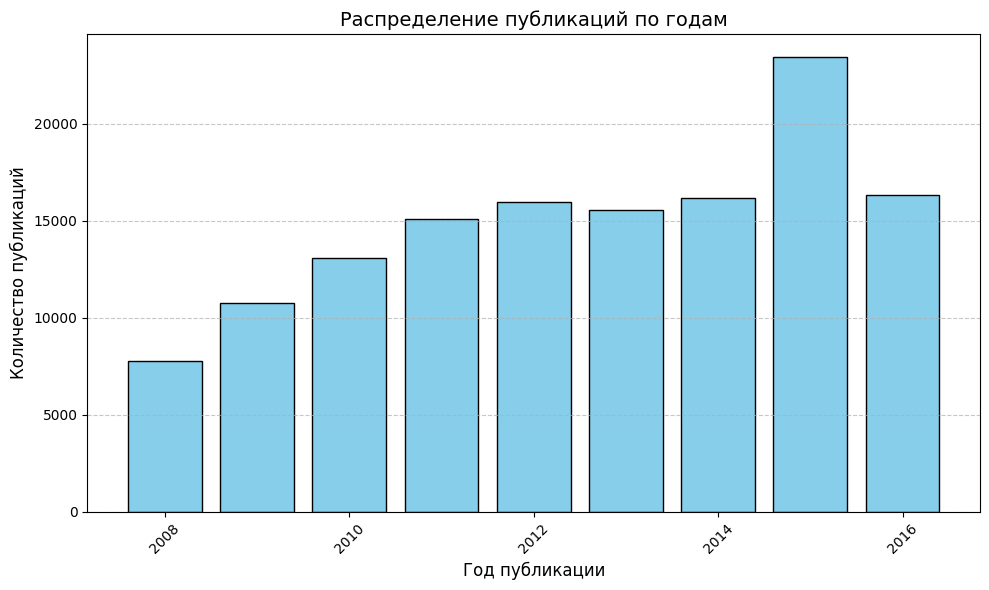

In [ ]:
# Данные для построения графика
df = train_df.copy()
df['published'] = pd.to_datetime(df['published']).dt.year  # Преобразование даты в год
ss = df['published'].value_counts()  # Подсчет количества публикаций по годам
ss = ss.sort_index()  # Сортировка по годам

# Построение графика
plt.figure(figsize=(10, 6))
plt.bar(ss.index, ss.values, color='skyblue', edgecolor='black')
plt.xlabel('Год публикации', fontsize=12)
plt.ylabel('Количество публикаций', fontsize=12)
plt.title('Распределение публикаций по годам', fontsize=14)
plt.xticks(rotation=45)  # Поворот подписей на оси X для читаемости
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Оптимизация расположения элементов графика
plt.show()

In [ ]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])
print('Размер исходного набора: ', len(train_df), \
      '\nРазмер обучающей подвыборки: ', train_size)
      #отделяем признаки от целевой переменной
X, y = train_df.loc[:, features], train_df['favs_lognorm']
X_test = test_df.loc[:, features]
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]
y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

Размер исходного набора:  134137 
Размер обучающей подвыборки:  93895


Для анализа контента (содержимого файлов howpop_*.jsonlines)
тспользуем TfidfVectorizer из пакета sklearn. TF-IDF (от англ. TF – term
frequency, IDF – inverse document frequency) – статистическая мера,
используемая для оценки важности слова в контексте документа, являющегося
частью коллекции документов или корпуса. Вес некоторого слова
пропорционален количеству употребления этого слова в документе, и обратно
пропорционален частоте употребления слова в других документах коллекции.
TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.
Основные параметры TfidfVectorizer в sklearn: – min_df – при построении словаря слова, которые встречаются реже,
чем указанное значение, игнорируются; – max_df – при построении словаря слова, которые встречаются чаще,
чем указанное значение, игнорируются; – analyzer – определяет, строятся ли признаки по словам или по
символам (буквам); – ngram_range – определяет, формируются ли признаки только из
отдельных слов или из нескольких слов (в случае с analyzer='char' задает
количество символов). Например, если указать analyzer='word' и
ngram_range=(1,3),то признаки будут формироваться из отдельных слов, из
пар слов и из троек слов; – stop_words – слова, которые игнорируются при построении матрицы.
Создадим объект TfidfVectorizer и обучим его на данных:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1,3))
vX_train_title = vectorizer_title.fit(X_train['title'])
print('vX_train_title.vocabulary_: ', len(vX_train_title.vocabulary_))
vX_valid_title = vectorizer_title.fit(X_valid['title'])
print('vX_train_title.vocabulary_:', len(vX_train_title.vocabulary_))
vX_test_title = vectorizer_title.fit(X_test['title'])
print('vX_train_title.vocabulary_: ', len(vX_train_title.vocabulary_))
X_train_title = vectorizer_title.fit_transform(X_train['title'])
print('X_train_title.shape: ', X_train_title.shape)
X_valid_title = vectorizer_title.transform(X_valid['title'])
print('X_valid_title.shape: ', X_valid_title.shape)
X_test_title = vectorizer_title.transform(X_test['title'])
print('X_test_title.shape: ', X_test_title.shape)

vX_train_title.vocabulary_:  50624
vX_train_title.vocabulary_: 28528
vX_train_title.vocabulary_:  2768
X_train_title.shape:  (93895, 50624)
X_valid_title.shape:  (40242, 50624)
X_test_title.shape:  (3990, 50624)


Получили три словаря и три матрицы TF-IDF. Для доступа к словарям
можно обратиться к полю vocabulary_ объекта TfidfVectorizer. К этому
времени объект должен быть обучен – должен быть вызван метод
fit_transform().

In [ ]:
vectorizer_title.vocabulary_

{'новогодний': 31497,
 'подарок': 36257,
 'блоггерам': 14241,
 'wordpress': 12172,
 'новогодний подарок': 31499,
 'сумасшедшие': 45476,
 'яйца': 50489,
 'или': 22661,
 'сервис': 42745,
 'для': 18811,
 'отслеживания': 34225,
 'посетителей': 37373,
 'или сервис': 22833,
 'сервис для': 42751,
 'для отслеживания': 19413,
 'или сервис для': 22834,
 'сервис для отслеживания': 42753,
 'сглаживание': 42460,
 'шрифтов': 49862,
 'отрисовка': 34214,
 'сглаживание шрифтов': 42461,
 'почему': 37632,
 'мне': 28231,
 'не': 30755,
 'нравится': 31925,
 'iphone': 5951,
 'почему мне': 37659,
 'мне не': 28233,
 'не нравится': 30851,
 'всеобщая': 16456,
 'доступность': 20285,
 'действии': 18272,
 'чем': 49165,
 'суть': 45504,
 'проекта': 39310,
 'ru': 9541,
 'search': 9842,
 'запускается': 21584,
 'понедельник': 37201,
 'mobile': 7315,
 'выбор': 16759,
 'способа': 44575,
 'связи': 42437,
 'обзор': 32095,
 'под': 36147,
 'windows': 11973,
 'под windows': 36185,
 'онлайн': 33063,
 'банкинг': 13661,
 'оформле

Построим TF-IDF-матрицы для этих же признаков, но с
использованием параметра analyzer='char'

In [ ]:
vectorizer_title_ch = TfidfVectorizer(analyzer='char')

vX_train_title_ch = vectorizer_title_ch.fit(X_train['title'])
print('vX_train_title_ch.vocabulary_: ', len(vX_train_title_ch.vocabulary_))
vX_valid_title_ch = vectorizer_title_ch.fit(X_valid['title'])
print('vX_valid_title_ch.vocabulary_: ', len(vX_valid_title_ch.vocabulary_))
vX_test_title_ch = vectorizer_title_ch.fit(X_test['title'])
print('vX_test_title_ch.vocabulary_:', len(vX_test_title_ch.vocabulary_))
X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
print('X_train_title_ch.shape: ', X_train_title_ch.shape)
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
print('X_valid_title_ch.shape: ', X_valid_title_ch.shape)
X_test_title_ch = vectorizer_title_ch.transform(X_test['title'])
print('X_test_title_ch.shape: ', X_test_title_ch.shape)

vX_train_title_ch.vocabulary_:  218
vX_valid_title_ch.vocabulary_:  165
vX_test_title_ch.vocabulary_: 136
X_train_title_ch.shape:  (93895, 218)
X_valid_title_ch.shape:  (40242, 218)
X_test_title_ch.shape:  (3990, 218)


Для обработки остальных признаков будем использовать
DictVectorizer из sklearn. Признаки ['author', 'flow', 'domain'] имеют
категориальную природу, для них TfidfVectorizer неприменим.

In [ ]:
from sklearn.feature_extraction import DictVectorizer
feats = ['author', 'flow', 'domain', 'title']
vectorizer_feats = DictVectorizer()

tmp_dict_train = X_train[feats].fillna('-').T.to_dict().values()
tmp_dict_valid = X_valid[feats].fillna('-').T.to_dict().values()
tmp_dict_test = X_test[feats].fillna('-').T.to_dict().values()

In [ ]:
X_train_feats = vectorizer_feats.fit_transform(tmp_dict_train)
X_valid_feats = vectorizer_feats.transform(tmp_dict_valid)
X_test_feats = vectorizer_feats.transform(tmp_dict_test)
print(X_train_feats.shape)
print(X_valid_feats.shape)
print(X_test_feats.shape)

(93895, 111482)
(40242, 111482)
(3990, 111482)


Выполним объединение полученных матриц:

In [ ]:
# объединение матриц, построенных на предыдущих этапах
X_train_new = scipy.sparse.hstack([X_train_title,\
                                   X_train_feats,\
                                   X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title,\
                                   X_valid_feats,\
                                   X_valid_title_ch])
X_test_new = scipy.sparse.hstack([X_test_title,\
                                  X_test_feats,\
                                  X_test_title_ch])
print(X_train_new.shape)
print(X_valid_new.shape)
print(X_test_new.shape)

(93895, 162324)
(40242, 162324)
(3990, 162324)


Для обучения выбрана линейная модель регрессии с L2
регуляризацией.

In [ ]:
%%time
model_1 = Ridge(alpha=.1, random_state=1)
model_1.fit(X_train_new, y_train)

CPU times: user 22.9 s, sys: 16.5 s, total: 39.4 s
Wall time: 25.4 s


Ridge(alpha=0.1, random_state=1)

In [ ]:
train_preds1 = model_1.predict(X_train_new)
valid_preds1 = model_1.predict(X_valid_new)
print('Ошибка на трейне: ', mean_squared_error(y_train, train_preds1))
print('Ошибка на тесте: ', mean_squared_error(y_valid, valid_preds1))

Ошибка на трейне:  0.0033498668127804505
Ошибка на тесте:  0.6982987113454213


Выполним обучение еще одной модели и проверим ошибки:

In [ ]:
%%time
model_2 = Ridge(alpha=1.0, random_state=1)
model_2.fit(X_train_new, y_train)

CPU times: user 8.81 s, sys: 6.61 s, total: 15.4 s
Wall time: 9.15 s


Ridge(random_state=1)

In [ ]:
train_preds2 = model_2.predict(X_train_new)
valid_preds2 = model_2.predict(X_valid_new)
print('Ошибка на трейне: ', mean_squared_error(y_train, train_preds2))
print('Ошибка на тесте: ', mean_squared_error(y_valid, valid_preds2))

Ошибка на трейне:  0.08633264425668048
Ошибка на тесте:  0.6840061221431166


**Индивидуальное задание**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_csv('insurance.csv')

# Преобразование категориальных переменных
label_encoders = {}
for col in ['sex', 'smoker', 'region']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col]) # преобразование значений категориальных переменных в числа

    label_encoders[col] = le

# Разделение на признаки и целевую переменную
X = df.drop(columns=['charges']) # все столбцы, кроме charges
y = (df['charges'] > df['charges'].median()).astype(int)  # 1 если стоимость страховки charges выше медианы, 0 - если ниже

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размеры выборок: X_train: {X_train.shape}, X_test: {X_test.shape}")


Размеры выборок: X_train: (1070, 6), X_test: (268, 6)


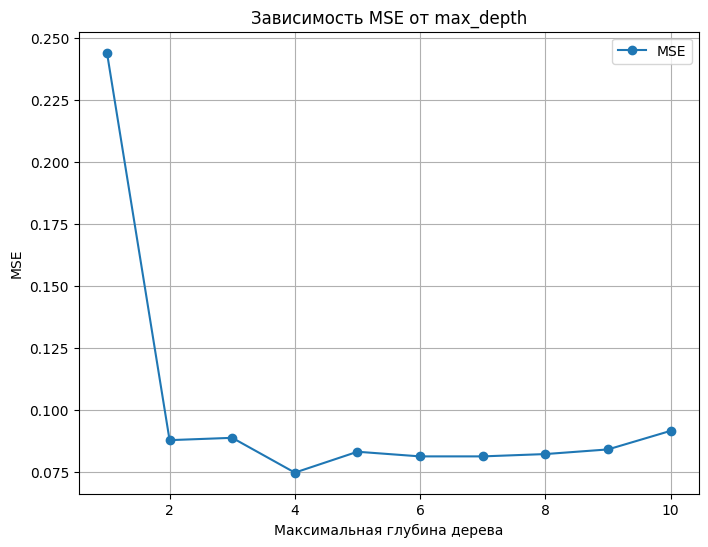

In [ ]:
depths = range(1, 11)
mse_scores = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42) # дерево решений с заданной глубиной
    # выполнение 10-кратной кросс-валидации
    mse = -np.mean(cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')) # возвращает отрицательные значения MSE, поэтому берется отрицательное значение результата, чтобы получить положительное значение MSE.
    mse_scores.append(mse) # вычисленный средний MSE добавляется в список mse_scores

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(depths, mse_scores, marker='o', label='MSE')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('MSE')
plt.title('Зависимость MSE от max_depth')
plt.legend()
plt.grid()
plt.show()


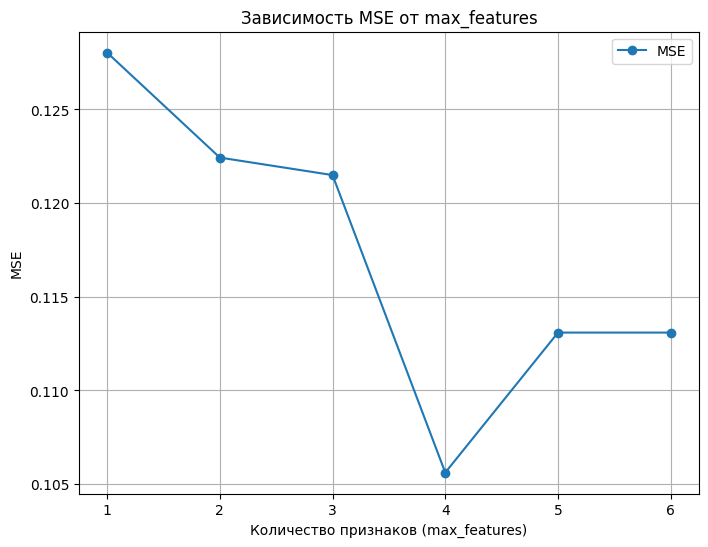

In [ ]:
# кол-во признаков, которые модель может использовать на каждом этапе построения дерева
features_range = range(1, X_train.shape[1] + 1)  # X_train.shape[1] возвращает количество признаков в обучающем наборе данных.
mse_scores_features = [] # массив со значениями MSE для каждой настройки max_features

for max_features in features_range: # создание дерева решений с максимальным кол-ом признаков
    model = DecisionTreeClassifier(max_features=max_features, random_state=42)
    mse = -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    mse_scores_features.append(mse)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(features_range, mse_scores_features, marker='o', label='MSE')
plt.xlabel('Количество признаков (max_features)')
plt.ylabel('MSE')
plt.title('Зависимость MSE от max_features')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Сетка параметров
param_grid = {
    'max_depth': depths,
    'max_features': features_range
}

# Поиск лучших параметров с помощью дерева решений и MSE
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший MSE: {-grid_search.best_score_}")

# Использование оптимальной модели
best_model = grid_search.best_estimator_

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)
# Оценка модели
best_rf_model = grid_search.best_estimator_
accuracy = best_rf_model.score(X_train, y_train)
print(f"Точность модели: {accuracy}")


Лучшие параметры: {'max_depth': 4, 'max_features': 4}
Лучший MSE: 0.07383177570093458
Точность модели: 0.9289719626168225


In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Сохранение оптимального дерева в формате .dot
export_graphviz(
    best_model,  # Используем лучшую модель
    out_file="optimal_decision_tree.dot",  # Имя выходного файла
    feature_names=X.columns,  # Имена признаков
    class_names=['Low', 'High'],  # Имена классов
    filled=True,  # Цветовая заливка
    rounded=True,  # Закругленные узлы
    special_characters=False  # Отключение специальных символов
)

# Конвертация .dot в .png с использованием graphviz
with open("optimal_decision_tree.dot") as f:
    dot_graph = f.read()

graph = graphviz.Source(dot_graph)
graph.render("optimal_decision_tree", format="png")  # Генерация .png

print("Оптимальное дерево сохранено в файл 'optimal_decision_tree.png'.")


Оптимальное дерево сохранено в файл 'optimal_decision_tree.png'.


In [ ]:
from sklearn.tree import export_graphviz

# Обучение модели
model.fit(X_train, y_train)

# Сохранение дерева в формате .dot без использования специальных символов
export_graphviz(
    best_model,
    out_file="decision_tree.dot",  # Файл сохранения
    feature_names=X_train.columns,  # Имена признаков
    class_names=['Low', 'High'],  # Имена классов
    filled=True,  # Цветовая заливка
    rounded=True,  # Закругленные узлы
    special_characters=False  # Отключение специальных символов
)

print("Упрощенное дерево сохранено в файл 'decision_tree.dot'.")
# Конвертация .dot в .png с использованием graphviz
with open("decision_tree.dot") as f:
    dot_graph = f.read()

graph = graphviz.Source(dot_graph)
graph.render("decision_tree", format="png")  # Генерация .png

print("Оптимальное дерево сохранено в файл 'decision_tree.png'.")

Упрощенное дерево сохранено в файл 'decision_tree.dot'.
Оптимальное дерево сохранено в файл 'decision_tree.png'.


**Решающие границы модели**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


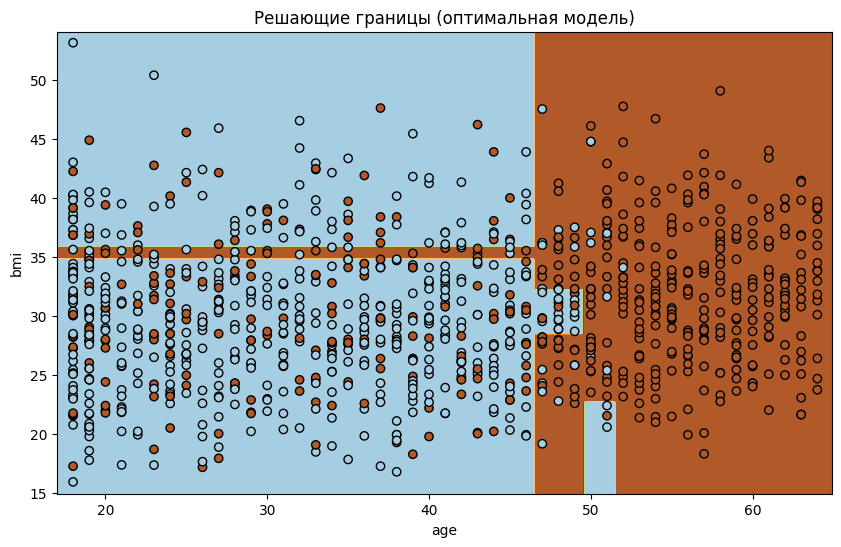

In [ ]:
# Использование оптимальной модели (best_model) для визуализации решающих границ
feature_1 = 'age'
feature_2 = 'bmi'

# Создаем новый набор данных только с выбранными признаками
X_train_2d = X_train[[feature_1, feature_2]]

# Дерево решений с оптимальными гиперпараметрами, найденными ранее
best_model_2d = DecisionTreeClassifier(
    max_depth=grid_search.best_params_['max_depth'],
    max_features=grid_search.best_params_['max_features'],
    random_state=42
)

# Переобучаем модель только на выбранных признаках
best_model_2d.fit(X_train_2d, y_train)

# Определение диапазонов значений для визуализации
x_min, x_max = X_train_2d[feature_1].min() - 1, X_train_2d[feature_1].max() + 1
y_min, y_max = X_train_2d[feature_2].min() - 1, X_train_2d[feature_2].max() + 1

# Создание сетки точек в пространстве значений наших признаков (age и bmi)
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Предсказание на сетке
Z = best_model_2d.predict(np.c_[xx.ravel(), yy.ravel()]) #преобразуем сетку в список точек, чтобы сделать предсказания
Z = Z.reshape(xx.shape)

# Визуализация решающих границ
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=1, cmap=plt.cm.Paired) # фоновая заливка под один из классов
plt.scatter(X_train_2d[feature_1], X_train_2d[feature_2], c=y_train, edgecolor='k', cmap=plt.cm.Paired)
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.title('Решающие границы (оптимальная модель)')
plt.show()
